# Coronary artery segmentation

Based on U-Net

In [2]:
%matplotlib inline
import os
import glob
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import cv2
from PIL import Image
import numpy as np

## Images path

In [17]:
# path
train_path = '../IMGC/training/'
test_path = '../IMGC/test/'

train_files = glob.glob(train_path + 'images/*.gif')
label_files = glob.glob(train_path + 'labels/*.gif')

test_files = glob.glob(test_path + 'images/*.gif')
test_label_files = glob.glob(test_path + 'labels/*.gif')

##  Load images to numpy array

In [18]:
def load_img(x_files, y_files):
    X = []
    y = []

    for x_path, y_path in zip(x_files, y_files):
        X.append(np.array(Image.open(x_path)))
        y.append(np.array(Image.open(y_path)))

    X = np.stack(X)[..., np.newaxis]
    X = X / 255
    y = np.stack(y)[..., np.newaxis]
    
    return X, y

In [19]:
X_train, y_train = load_img(train_files, label_files)
X_test, y_test = load_img(test_files, test_label_files)

In [20]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(20, 512, 512, 1) (20, 512, 512, 1)
(14, 512, 512, 1) (14, 512, 512, 1)


# Test purpose: Concat test samples to training sample
** Remove after data cleanup **

In [21]:
X_train = np.append(X_train, X_test, axis=0)
y_train = np.append(y_train, y_test, axis=0)

In [22]:
print(X_train.shape, y_train.shape)

(34, 512, 512, 1) (34, 512, 512, 1)


** Histogram of training image after normalization. **

(array([   1299.,    2100.,     831.,   47112.,  107795.,   52206.,
          21567.,    9029.,   12573.,    7632.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

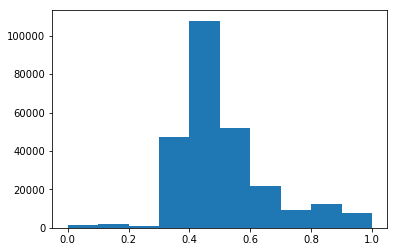

In [23]:
plt.hist(np.reshape(X_train[0].squeeze(), (512*512)))

** Histogram of label **  
Highly unbalanced. May cause problems.

(array([ 235803.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,   26341.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

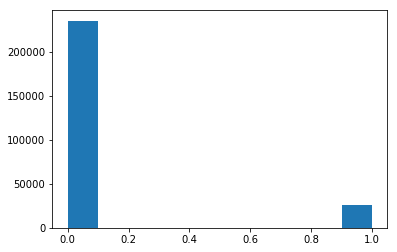

In [24]:
plt.hist(np.reshape(y_train[0].squeeze(), (512*512)))

# Train U-net

In [25]:
from keras.models import Model, load_model
from keras.layers import Input, Conv2D, UpSampling2D, Reshape, core, MaxPooling2D, Dense, Flatten
from keras.layers import Concatenate, concatenate, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [32]:
def u_net(patch_height,patch_width):
    inputs = Input((patch_height, patch_width,1))

    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)    
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = BatchNormalization()(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv5))
    merge6 = concatenate([conv4,up6])
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7])
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8])
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9])
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(input = inputs, output = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

    return model

In [33]:
model_path = './whole_model.h5'

In [34]:
# change monitor to 'val_acc' when using validation set
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
checkpoint = ModelCheckpoint(model_path, monitor='acc', verbose=0, save_best_only=True)
tboard = TensorBoard()
early_stop = EarlyStopping(monitor='loss', min_delta=0, patience=5)

In [35]:
if os.path.isfile(model_path):
    model = load_model(model_path)
else:
    model = u_net(512, 512)
    model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 512, 512, 1)       0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 512, 512, 64)      640       
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 512, 512, 64)      36928     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 256, 256, 64)      0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 256, 256, 128)     73856     
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 256, 256, 128)     147584    
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 128, 128, 128)     0         
__________

/home/rtvdnn/anaconda3/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:47: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [36]:
# cl_weight = {0:0.1, 1:1.0}
model.fit(X_train, y_train, batch_size=1, epochs=100, verbose=1, callbacks=[checkpoint, tboard, early_stop])
#model.save(model_path) 
#validation_data=(X_test, y_test)

Epoch 1/100
34/34 [==============================] - 471s - loss: 0.3094 - acc: 0.9013    
Epoch 2/100
34/34 [==============================] - 475s - loss: 0.2279 - acc: 0.9022    
Epoch 3/100
34/34 [==============================] - 471s - loss: 0.1869 - acc: 0.9022    
Epoch 4/100
34/34 [==============================] - 471s - loss: 0.1705 - acc: 0.9366    
Epoch 5/100
34/34 [==============================] - 471s - loss: 0.1549 - acc: 0.9447    
Epoch 6/100
34/34 [==============================] - 469s - loss: 0.1576 - acc: 0.9425    
Epoch 7/100
34/34 [==============================] - 471s - loss: 0.1467 - acc: 0.9486    
Epoch 8/100
34/34 [==============================] - 472s - loss: 0.1460 - acc: 0.9514    
Epoch 9/100
34/34 [==============================] - 471s - loss: 0.1382 - acc: 0.9528    
Epoch 10/100
34/34 [==============================] - 474s - loss: 0.1334 - acc: 0.9572    
Epoch 11/100
34/34 [==============================] - 472s - loss: 0.1310 - acc: 0.9561  

In [37]:
model.save('./backup_model.h5')

In [42]:
def visualize_prediction(predict, truth, origin, file_names):
    fig = plt.figure(figsize=(10, 5 * predict.shape[0]))
    gs = GridSpec(predict.shape[0], 3)
    for i, file_name in enumerate(file_names):
        fname = os.path.basename(file_name)
        # original image
        img = np.reshape(origin[i], (512, 512))
        ax = plt.subplot(gs[i, 0])
        ax.imshow(img, 'gray'), ax.set_title('origin_' + fname), ax.axis('off')
        # binarized prediction
        img = np.copy(np.reshape(predict[i], (512,512)))
        ax = plt.subplot(gs[i, 1])
        img[img >= 0.5] = 1
        img[img < 0.5] = 0
        ax.imshow(img, 'gray'), ax.set_title('predict_' + fname), ax.axis('off')
        # truth
        img = np.reshape(truth[i], (512,512))    
        ax = plt.subplot(gs[i, 2])
        ax.imshow(img, 'gray'), ax.set_title('truth_' + fname), ax.axis('off')
    plt.show()

In [39]:
predict_test = model.predict(X_test, batch_size=2, verbose=1)
print(predict_test.shape)

14/14 [==============================] - 55s    
(14, 512, 512, 1)


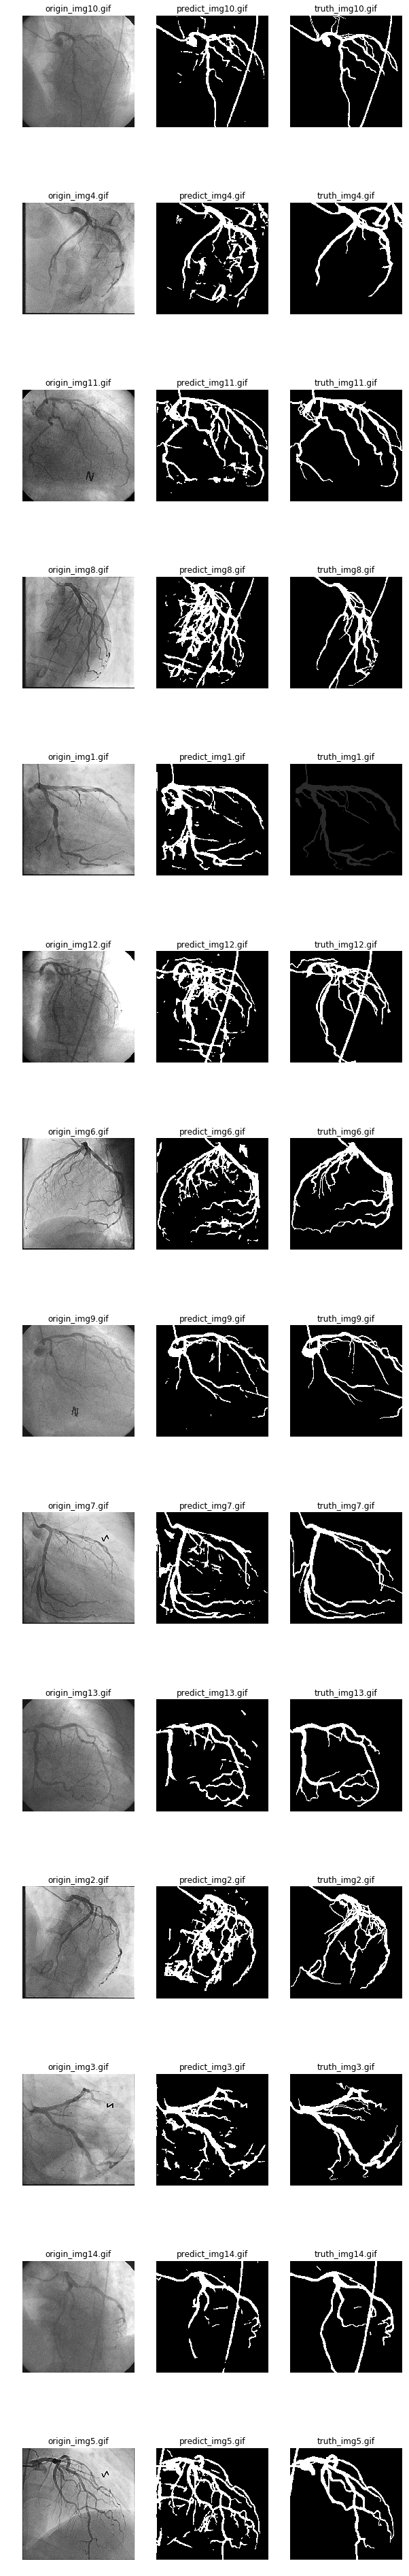

In [43]:
visualize_prediction(predict_test, y_test, X_test, test_files)

In [41]:
#predict_train = model.predict(X_train, batch_size=2, verbose=1)
visualize_prediction(predict_train, y_train, X_train, test_files)

NameError: name 'predict_train' is not defined

In [17]:
#from segmentation import chan_vese
filepath="../resource"
filenames=glob.glob(filepath+'/I0*')

reader=SimpleITK.ImageFileReader()

reader.SetFileName(filenames[0])
itkimage0=reader.Execute()
data0=SimpleITK.GetArrayFromImage(itkimage0)
reader.SetFileName(filenames[1])
itkimage1=reader.Execute()
data1=SimpleITK.GetArrayFromImage(itkimage1)

no=30
targetdata=data0[no]
edges=cv2.Canny(targetdata,100,200)
'''
cv = chan_vese(data1[no], mu=0.1, lambda1=1, lambda2=3, tol=1e-3, max_iter=100,
               dt=0.5, init_level_set="checkerboard", extended_output=True)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 9),
                         sharex=True, sharey=True,
                         subplot_kw={'adjustable': 'box-forced'})

ax=axes.ravel()

ax[0].imshow(data0[no], cmap=plt.cm.gray)
ax[0].axis('off')
ax[1].imshow(data1[no], cmap=plt.cm.gray)
ax[1].axis('off')
ax[2].imshow(cv[0], cmap=plt.cm.gray)
ax[2].axis('off')
ax[3].imshow(edges, cmap=plt.cm.gray)
ax[3].axis('off')
'''

'\ncv = chan_vese(data1[no], mu=0.1, lambda1=1, lambda2=3, tol=1e-3, max_iter=100,\n               dt=0.5, init_level_set="checkerboard", extended_output=True)\n\nfig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 9),\n                         sharex=True, sharey=True,\n                         subplot_kw={\'adjustable\': \'box-forced\'})\n\nax=axes.ravel()\n\nax[0].imshow(data0[no], cmap=plt.cm.gray)\nax[0].axis(\'off\')\nax[1].imshow(data1[no], cmap=plt.cm.gray)\nax[1].axis(\'off\')\nax[2].imshow(cv[0], cmap=plt.cm.gray)\nax[2].axis(\'off\')\nax[3].imshow(edges, cmap=plt.cm.gray)\nax[3].axis(\'off\')\n'

In [18]:
from scipy import ndimage as ndi
from skimage.filters import sobel
from skimage import morphology

ret,thres=cv2.threshold(targetdata,120,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
#ret,thres=cv2.threshold(data0[no],120,255,cv2.THRESH_BINARY)
edges=cv2.Canny(targetdata,170,200)
fill=ndi.binary_fill_holes(edges)
mark=sobel(targetdata)
img_c=morphology.remove_small_objects(edges,300)
'''
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 9),
                         sharex=True, sharey=True,
                         subplot_kw={'adjustable': 'box-forced'})


ax=axes.ravel()
ax[0].imshow(edges, cmap=plt.cm.gray)
ax[0].axis('off')
ax[1].imshow(mark, cmap=plt.cm.gray)
ax[1].axis('off')
'''

"\nfig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 9),\n                         sharex=True, sharey=True,\n                         subplot_kw={'adjustable': 'box-forced'})\n\n\nax=axes.ravel()\nax[0].imshow(edges, cmap=plt.cm.gray)\nax[0].axis('off')\nax[1].imshow(mark, cmap=plt.cm.gray)\nax[1].axis('off')\n"

(-0.5, 511.5, 511.5, -0.5)

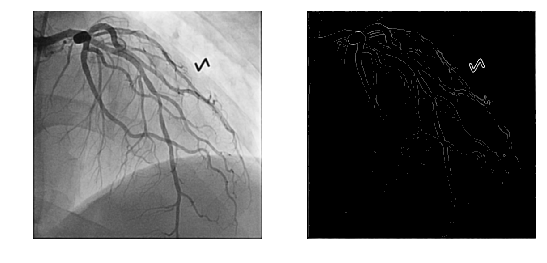

In [20]:
#boun=SimpleITK.BinaryThreshold(itkimage1[no],0,255,1,0)

blurred = cv2.GaussianBlur(targetdata, (5, 5), 0)
sobelX = cv2.Sobel(blurred, cv2.CV_16S, 1, 0)
sobelY = cv2.Sobel(blurred, cv2.CV_16S, 0, 1)
sobel = np.hypot(sobelX, sobelY)/255

sobel2=sobel.copy()
sobel2[sobel2<=0.4]=0

element=cv2.getStructuringElement(cv2.MORPH_RECT,(2,2))
mask=cv2.erode(sobel2,element,iterations=1)
mask2=cv2.dilate(mask,element, iterations=1)
mask3=cv2.erode(mask2,element)
mask4=mask3.copy()
mask4[mask4>0]=1
#cv2.imshow('image',sobel)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 9),
                         sharex=True, sharey=True,
                         subplot_kw={'adjustable': 'box-forced'})


ax=axes.ravel()
ax[0].imshow(blurred, cmap=plt.cm.gray)
ax[0].axis('off')
ax[1].imshow(mask3, cmap=plt.cm.gray)
ax[1].axis('off')

In [7]:
sobel.astype(float)
cv2.imshow('image',sobel/255)

In [9]:
import sys

boun=SimpleITK.BinaryThreshold(data1[no],0,upperThreshold,1,0)
boun2=SimpleITK.BinaryMorphologicalColosing(boun)
boun3=SimpleITK.BinaryGrindPeak(boun2)
boun4=SimpleITK.Cast(boun3, image.GetPixelID())

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 9),
                         sharex=True, sharey=True,
                         subplot_kw={'adjustable': 'box-forced'})
ax[0].imshow(boun, cmap=plt.cm.gray)
ax[0].axis('off')
ax[1].imshow(boun2, cmap=plt.cm.gray)
ax[1].axis('off')
ax[0].imshow(boun3, cmap=plt.cm.gray)
ax[0].axis('off')
ax[1].imshow(boun4, cmap=plt.cm.gray)
ax[4].axis('off')

plt.show()

NameError: name 'upperThreshold' is not defined

**Medial axis skeletonization**

The medial axis of an object is the set of all points having more than one
closest point on the object's boundary. It is often called the *topological
skeleton*, because it is a 1-pixel wide skeleton of the object, with the same
connectivity as the original object.

Here, we use the medial axis transform to compute the width of the foreground
objects. As the function ``medial_axis`` returns the distance transform in
addition to the medial axis (with the keyword argument ``return_distance=True``),
it is possible to compute the distance to the background for all points of
the medial axis with this function. This gives an estimate of the local width
of the objects.

For a skeleton with fewer branches, ``skeletonize`` or ``skeletonize_3d``
should be preferred.



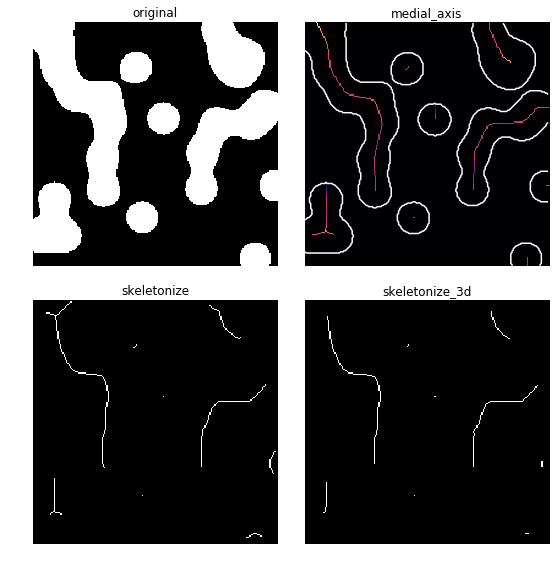

In [10]:
from skimage.morphology import medial_axis, skeletonize, skeletonize_3d
from skimage.data import binary_blobs

# Generate the data
data = binary_blobs(200, blob_size_fraction=.2, volume_fraction=.35, seed=1)

# Compute the medial axis (skeleton) and the distance transform
skel, distance = medial_axis(data, return_distance=True)

# Compare with other skeletonization algorithms
skeleton = skeletonize(data)
skeleton3d = skeletonize_3d(data)

# Distance to the background for pixels of the skeleton
dist_on_skel = distance * skel

from skimage.util.colormap import magma

fig, axes = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True,
                         subplot_kw={'adjustable': 'box-forced'})
ax = axes.ravel()

ax[0].imshow(data, cmap=plt.cm.gray, interpolation='nearest')
ax[0].set_title('original')
ax[0].axis('off')

ax[1].imshow(dist_on_skel, cmap=magma, interpolation='nearest')
ax[1].contour(data, [0.5], colors='w')
ax[1].set_title('medial_axis')
ax[1].axis('off')

ax[2].imshow(skeleton, cmap=plt.cm.gray, interpolation='nearest')
ax[2].set_title('skeletonize')
ax[2].axis('off')

ax[3].imshow(skeleton3d, cmap=plt.cm.gray, interpolation='nearest')
ax[3].set_title('skeletonize_3d')
ax[3].axis('off')

fig.tight_layout()
plt.show()